# Оглавление:
1. [Импорт данных и изучение общей информации](#start)
2. [Предобработка данных](#predobrabotka)
3. [Исследовательский анализ данных](#analysis)  
   3.1. [Подготовка данных к анализу](#prepare)  
   3.2. [Исследовательский анализ данных](#research)
4. [Анализ программы лояльности](#loyality)  
   4.1. [Графики куммулятивного среднего чека и среднего количества заказов](#cummulative)  
   4.2. [Средний чек](#meanprice)  
   4.3. [Среднее количество заказов](#meancount)
5. [Проверка статистических гипотез](#ab_tests)
6. [Вывод и рекомендации](#conclusion)

# Ритейл — Анализ программы лояльности
Датасет содержит данные о покупках в магазине строительных материалов «Строили, строили и наконец построили». Все покупатели могут получить доступ в магазин с использованием персональных карт. За 200 рублей в месяц они могут стать участниками программы лояльности. В программу включены скидки, специальные предложения, подарки.  
Задача исследования: анализ программы лояльности в магазине строительных материалов, оценка влияния программы лояльности на основные метрики магазина.  
Заказчик исследования: менеджер проекта, отвечающий за программу лояльности.  
Результат исследования: если программа лояльности эффективна, то необходимо распространить ее на большее число клиентов. Если неэффективна - предложить способы повышения эффективности либо предложить другую программу.  
Исследуемый период времени: период, представленный в данных.  
Проводилось ли исследование раньше: это новый вид исследования.


<a id="start"></a> 
### Импорт данных и изучение общей информации 

In [1]:
# Импортируем библиотеки:

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as stats

<span style="color:blue">Библиотеки импортированы.</span>

In [2]:
# Загрузим данные в переменные:

product = pd.read_csv('https://code.s3.yandex.net/datasets/product_codes.csv')
retail = pd.read_csv('https://code.s3.yandex.net/datasets/retail_dataset.csv')
display(product.head())
display(retail.head())

,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


<span style="color:blue">Данные в переменные загружены.</span>

In [3]:
# Изучим информацию о датафреймах:

product.info()
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   ShopID           105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


<span style="color:blue">В датафрейме product содержатся данные о стоимости одной единицы каждого товара в строительном магазине. Датафрейм насчитывает 2 столбца и 9969 строк. Типы данных столбцов соответствуют их фактическому содержимому, менять типы данных не требуется. В датафрейме retail содержатся данные о покупках в этом же строительном магазине. Датафрейм содержит информацию об id заказа, товара, покупателя и магазина, дате покупки и количестве товара, а также является ли покупатель участником программы лояльности. Датафрейм насчитывает 7 столбцов и 105335 строк. Не все типы данных столбцов соответствуют их фактическому содержимому, тип данных будет изменен ниже. Проверка на дубликаты и пропуски будет также проведена ниже.</span>

<a id="predobrabotka"></a> 
### Предобработка данных

In [4]:
# 1. Проверим данные на пропуски:

print(product.isna().sum())
print(retail.isna().sum())

productID        0
price_per_one    0
dtype: int64
purchaseid             0
item_ID                0
Quantity               0
purchasedate           0
CustomerID         36210
ShopID                 0
loyalty_program        0
dtype: int64


<span style="color:blue">Обнаружены 36210 пропусков в столбце CustomerID датафрейма retail. Число пропусков составляет примерно треть от общего количества строк в датафрейме, поэтому их удаление может привести к искажению данных. При дальнейшем анализе необходимо учитывать наличие этих пропусков.</span>

In [5]:
# 2. Проверим данные на дубликаты:

print(product.duplicated().sum())
print(retail.duplicated().sum())

0
1033


<span style="color:blue">В датафрейме retail обнаружены 1033 полных дубликатов. Ввиду малого количества целесообразно их удалить.</span>

In [6]:
# Удалим дубликаты:

retail = retail.drop_duplicates()
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104302 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       104302 non-null  object 
 1   item_ID          104302 non-null  object 
 2   Quantity         104302 non-null  int64  
 3   purchasedate     104302 non-null  object 
 4   CustomerID       68154 non-null   float64
 5   ShopID           104302 non-null  object 
 6   loyalty_program  104302 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.4+ MB


<span style="color:blue">Дубликаты удалены, в датафрейме retail осталось 104302 строки, что на 1033 меньше, чем было.</span>

In [7]:
# 3. Проверим, не попали ли одни и те же клиенты в разные группы - с программой лояльности и без нее:

print(retail['CustomerID'].nunique())
print(retail.groupby('loyalty_program')['CustomerID'].nunique())

1749
loyalty_program
0.0    1162
1.0     587
Name: CustomerID, dtype: int64


<span style="color:blue">В датафрейме 1749 уникальных customerid. Также в датафрейме 1162 уникальных customerid, не участвующих в программе, и 587 уникальных customerid, участвующих в программе, что в сумме дает 1749 уникальных записей. Таким образом, клиенты, одновременно попадающие в разные группы, отсутствуют.</span>

In [8]:
# 4. Переименуем названия столбцов датафрейма product на более лаконичные:

product = product.rename(columns={'productID':'product_id', 'price_per_one': 'price_per_item'})
product.head()

,product_id,price_per_item
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


<span style="color:blue">Столбцы переименованы.</span>

In [9]:
# Переименуем названия столбцов датафрейма retail на более лаконичные:

retail = retail.rename(columns={'purchaseid':'purchase_id', 'item_ID': 'item_id', 'Quantity': 'quantity', 
                                'purchasedate': 'purchase_date', 'CustomerID': 'customer_id', 'ShopID': 'shop_id'})
retail.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


<span style="color:blue">Столбцы также переименованы.</span>

In [10]:
# 5. Заменим тип данных в столбце 'loyalty_program' на int:

retail['loyalty_program'] = retail['loyalty_program'].astype(int)
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104302 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchase_id      104302 non-null  object 
 1   item_id          104302 non-null  object 
 2   quantity         104302 non-null  int64  
 3   purchase_date    104302 non-null  object 
 4   customer_id      68154 non-null   float64
 5   shop_id          104302 non-null  object 
 6   loyalty_program  104302 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.4+ MB


<span style="color:blue">Тип данных столбца 'loyalty_program' изменен. Тип данных в столбце 'customer_id' на int менять не будем, т.к. в этом столбце присутствуют пропуски NaN, которые не позволят просто так поменять тип данных.</span>

In [11]:
# Также поменяем тип данных столбца 'purchase_date' на datetime:

retail['purchase_date'] = pd.to_datetime(retail['purchase_date'])
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104302 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchase_id      104302 non-null  object        
 1   item_id          104302 non-null  object        
 2   quantity         104302 non-null  int64         
 3   purchase_date    104302 non-null  datetime64[ns]
 4   customer_id      68154 non-null   float64       
 5   shop_id          104302 non-null  object        
 6   loyalty_program  104302 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.4+ MB


<span style="color:blue">Тип данных столбца 'purchase_date' изменен на datetime.</span>

<span style="color:blue">
Общий вывод по результатам предобработки данных:
    
- В датафрейме retail обнаружены 36210 пропусков в столбце CustomerID. Число пропусков составляет примерно треть от общего количества строк в датафрейме, поэтому их удаление может привести к искажению данных, поэтому такие пропуски не удалялись. В датафрейме product пропусков нет.
- В датафрейме retail обнаружены 1033 полных дубликатов. Ввиду малого количества они были удалены.
- Клиенты, одновременно попадающие в программу лояльности и не состоящие в ней, отсутствуют.
- Столбцы обоих датафреймов переименованы: названия приведены к нижнему регистру, изменены на более лаконичные, где необходимо, добавлены пробелы в виде нижнего подчеркивания.
- Тип данных столбца 'loyalty_program' в датафрейме retail изменен на int, а тип данных столбца 'purchase_date' изменен на datetime. 
</span>

<a id="analysis"></a> 
### Исследовательский анализ данных

<a id="prepare"></a> 
#### Подготовка данных к анализу

In [12]:
# 1. Чтобы в дальнейшем анализировать информацию о среднем чеке в программе лояльности и вне ее,
# необходимо перенести информацию о ценах из таблицы product в retail, для чего сначала посмотрим на цены в product:

product['product_id'].value_counts()

DOT       174
M          59
S          29
POST       15
D          13
         ... 
22048       1
90152C      1
85031B      1
84670       1
21456       1
Name: product_id, Length: 3159, dtype: int64

<span style="color:blue">В таблице product одни и те же товары имеют разные цены. Например, товар с product_id 'DOT' имеет 174 разных цены. Целесообразно рассчитать средние или медианные цены по каждому товару.</span>

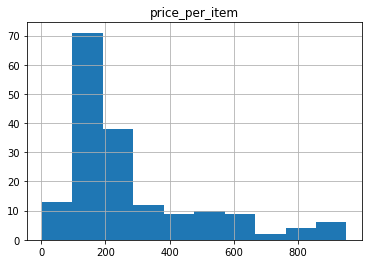

In [13]:
# Чтобы определить, средние или медианные цены брать за основу, посмотрим на выбросы в ценах,
# для чего построим гистограмму цен, например, по товару с item_id 'DOT':

product[product['product_id'] =='DOT'].hist()
plt.show()

<span style="color:blue">Цены на товар 'DOT' имеет большое количество выбросов. Вероятно, что и цены на другие товары имеют выбросы. Поэтому целесообразно брать медианные цены.</span>

In [14]:
# Найдем медианные цены на товары в таблице product, сохранив их в датафрейм price_per_product.
# Сформируем датафрейм с медианными ценами:

price_per_product = product.groupby('product_id')['price_per_item'].median()
price_per_product.head()

product_id
10002     1.63
10080     0.85
10120     0.21
10123C    0.65
10124A    0.42
Name: price_per_item, dtype: float64

<span style="color:blue">Медианные цены найдены.</span>

In [15]:
# Объединим таблицу retail с таблицей price_per_product в таблицу data:

data = retail.merge(price_per_product, left_on='item_id', right_on='product_id', how='left')

# добавим столбец с ценой заказа в разрезе каждого товара:
data['full_price_per_item'] = data['quantity']*data['price_per_item']

display(data.head())
data.info()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_item,full_price_per_item
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0,1.63,17.93
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1,3.29,0.00
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1,1.63,11.41
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1,4.37,0.00
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1,5.75,0.00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 104302 entries, 0 to 104301
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   purchase_id          104302 non-null  object        
 1   item_id              104302 non-null  object        
 2   quantity             104302 non-null  int64         
 3   purchase_date        104302 non-null  datetime64[ns]
 4   customer_id          68154 non-null   float64       
 5   shop_id              104302 non-null  object        
 6   loyalty_program      104302 non-null  int64         
 7   price_per_item       104302 non-null  float64       
 8   full_price_per_item  104302 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 8.0+ MB


<span style="color:blue">Цены добавлены. В таблице data 104302 строки, как и было в таблице retail, т.е. ничего лишнего не добавилось. Общий датафрейм готов для анализа.</span>

/opt/tljh/user/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


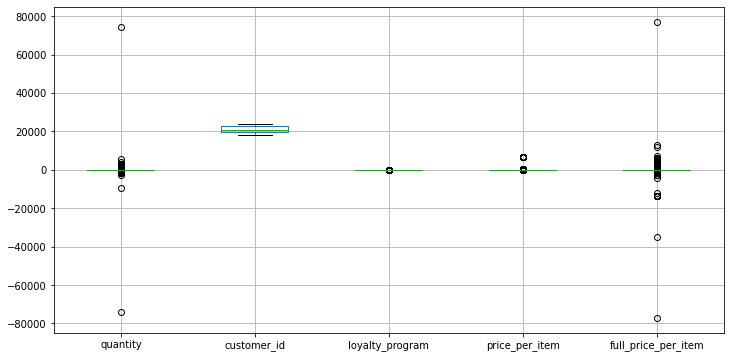

In [16]:
# Построим диаграмму размаха по датафрейму data:

data.boxplot(figsize=(12, 6))
plt.show()

<span style="color:blue">Диаграмма размаха построена.</span>

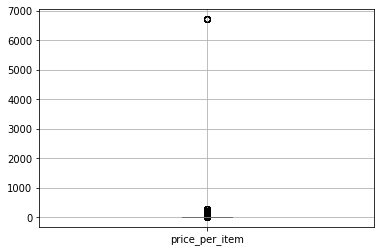

In [17]:
# Для наглядности отдельно построим диаграмму размаха для столбца price_per_item:

data.boxplot(column = ['price_per_item'])
plt.show()

<span style="color:blue">По двум диаграммам в столбце quantity видны отрицательные и нулевые значения, а также выбросы на отметке примерно 80 тыс. В столбце price_per_item видны выбросы на отметке примерно 7 тыс. Как следствие, в столбце full_price_per_item также видны отрицательные и нулевые значения и выбросы на отметке примерно 10 тыс. и 80 тыс. Выбросы обработаем ниже.</span>

In [18]:
# Построим гистограммы по столбцу purchase_date в программе лояльности и вне ее:

data[data['loyalty_program']==0].hist(column=['purchase_date'], figsize=(8, 4), bins = 30)
plt.show()
data[data['loyalty_program']==1].hist(column=['purchase_date'], figsize=(8, 4), bins = 30)
plt.show()

ValueError: hist method requires numerical columns, nothing to plot.

<span style="color:blue">В программе лояльности и вне ее наблюдается всплеск продаж в период с 01 по 15 декабря и перерыв в продажах в период примерно 20 декабря по 05 января. Вероятно, всплеск продаж связан с предстоящими новогодними праздниками. Какой-либо разницы между программой лояльности и обычными продажами не усматривается.</span>

In [ ]:
# 3. Посмотрим на отрицательные и нулевые значения количества товаров в заказах:

print('Количество заказов с нулевым или отрицательным числом товаров равно', data[data['quantity'] <= 0]['purchase_id'].count())

<span style="color:blue">В датафрейме retail присутствует 34438 заказов с нулевым или отрицательным числом товаров. Данные заказы не дают никакой информации для анализа успешности программы лояльности, поэтому их целесообразно удалить.</span>

In [ ]:
# Оставим в датафрейме data только заказы с положительным числом товаров:

data = data[data['quantity'] > 0]
data.info()

<span style="color:blue">Заказы с нулевым и отрицательным числом товаров в количестве 34438 убраны. В датафрейме осталось 69864 строки.</span>

In [ ]:
# Также уберем выбросы в столбце quantity на отметке примерно 80 тыс.

data = data[data['quantity'] < 20000]
data.info()

<span style="color:blue">Исчезла одна строка с одним выбросом в столбце quantity.</span>

In [ ]:
# 4. Посмотрим, какие цены встречаются в датафрейме data:

print('Минимальная цена товаров в датафрейме составляет', data['price_per_item'].min())
print('Количество товаров с нулевой ценой', data[data['price_per_item'] == 0]['purchase_id'].count())

<span style="color:blue">В датафрейме data присутствуют 11 заказов с нулевой ценой. Такие заказы не приносят денег, а, значит, не помогут в анализе программы лояльности, поэтому их целесообразно удалить.</span>

In [ ]:
# Оставим в датафрейме data только заказы с положительной ценой товаров:

data = data[data['price_per_item'] > 0]
data.info()

<span style="color:blue">11 заказов с нулевой ценой удалены, в датафрейме осталось 69853 строк. Все лишние данные из датафрейма исключены.</span>

In [ ]:
# Построим еще раз диаграмму размаха по столбцу price_per_item:

data.boxplot(column = ['price_per_item'])
plt.show()

<span style="color:blue">Выброс в цене товара на отметке 7 тыс. исчез вместе с выбросом в количестве товаров.</span>

<a id="research"></a> 
#### Исследовательский анализ данных

In [ ]:
# 1. Посмотрим на общую информацию в обновленном датафрейме, для чего сначала посмотрим на период исследования:

print(data['purchase_date'].min())
print(data['purchase_date'].max())

<span style="color:blue">В датафрейме размещены данные за период с 01 декабря 2016 года по 28 февраля 2017 года.</span>

In [ ]:
# 2. Посчитаем количество уникальных клиентов в программе лояльности и вне ее:

data.groupby('loyalty_program')['customer_id'].nunique()

<span style="color:blue">В программе лояльности зарегистрирован 561 клиент, не зарегистрированы 1109 клиентов.</span>

In [ ]:
# 3. Посчитаем количество уникальных заказов в программе лояльности и вне ее:

data.groupby('loyalty_program')['purchase_id'].nunique()

<span style="color:blue">В программе лояльности клиентами сделано 1120 заказов, вне ее - 2578 заказов.</span>

In [ ]:
# 4. Посчитаем, какие магазины более популярны у клиентов в программе лояльности и вне ее:

print('Обычные продажи')
print(data[data['loyalty_program']==0].groupby(['loyalty_program', 'shop_id'])['purchase_id']
      .nunique()
      .sort_values(ascending = False)
      .head())
print("Всего", data[data['loyalty_program']==0]['shop_id'].nunique(), "магазинов")
print()
print('Программа лояльности')
print(data[data['loyalty_program']==1].groupby(['loyalty_program', 'shop_id'])['purchase_id']
      .nunique()
      .sort_values(ascending = False)
      .head())
print("Всего", data[data['loyalty_program']==1]['shop_id'].nunique(), "магазина")

<span style="color:blue">В программе лояльности и вне ее самый популярный магазин с большим отрывом - Shop 0. Примечательно, что в программе лояльности клиенты делают заказы только в четырех магазинах, а в обычных продажах - во всех 30.</span>

In [ ]:
# 5. Посчитаем, какие товары наиболее популярны у клиентов в программе лояльности и вне ее:

print('Обычные продажи')
print(data[data['loyalty_program']==0].groupby(['loyalty_program', 'item_id'])['purchase_id']
    .nunique()
    .sort_values(ascending = False)
    .head())
print()
print('Программа лояльности')
print(data[data['loyalty_program']==1].groupby(['loyalty_program', 'item_id'])['purchase_id']
    .nunique()
    .sort_values(ascending = False)
    .head())

<span style="color:blue">В программе лояльности и вне ее в топ-2 одни и те же товары с item_id 85123A и 22469. Остальные товары из топ-5 отличаются.</span>

In [ ]:
# 6. Посчитаем, в какие дни недели клиенты из программы лояльности и вне ее чаще совершают покупки,
# для чего создадим столбец с днем недели:

data['weekday'] = data['purchase_date'].dt.dayofweek
print('Обычные продажи')
print(data[data['loyalty_program']==0].groupby(['loyalty_program', 'weekday'])['purchase_id']
      .nunique()
      .sort_values(ascending = False)
      .head())
print()
print('Программа лояльности')
print(data[data['loyalty_program']==1].groupby(['loyalty_program', 'weekday'])['purchase_id']
      .nunique()
      .sort_values(ascending = False)
      .head())

<span style="color:blue">В программе лояльности и вне ее распределение покупок по дням недели одинаковое. Самое большое число покупок в четверг, затем по убывающей среда, вторник, понедельник и пятница. В выходные покупатели совершают меньше всего покупок. Видимо, потребляют то, что купили за неделю.</span>

<span style="color:blue">
Общий вывод по результатам исследовательского анализа данных:

- Сформирован общий датафрейм из таблицы retail с включением в него столбца с медианными ценами из таблицы product. В общий датафрейм добавлен столбец с ценой заказа в разрезе каждого товара. 
- Из общего датафрейма удалены заказы с отрицательным  и нулевым числом товаров, выбросы в количестве товаров, заказы с нулевой ценой товаров и выбросы в цене товаров.
- Согласно данным сформированного общего датафрейма данные относятся к периоду с 01 декабря 2016 год по 28 февраля 2017 год. В программе лояльности зарегистрирован 561 клиент, не зарегистрированы 1109 клиентов. В программе лояльности клиентами сделано 1120 заказов, вне ее - 2578 заказов. Самый популярный магазин у клиентов в программе лояльности и вне ее с большим отрывом - Shop 0. Клиенты в программе лояльности и вне ее больше всего покупают товары с item_id 85123A и 22469. Распределение покупок по дням недели в программе лояльности и вне ее одинаковое, больше всего покупок совершается в четверг, меньше всего - в выходные дни.
</span>

<a id="loyality"></a> 
### Анализ программы лояльности

<a id="cummulative"></a> 
#### Графики куммулятивного среднего чека и среднего количества заказов

In [ ]:
# 1. Построим графики изменения среднего чека и среднего количества заказов по дням, для чего сначала создадим столбец с датой:

data['date'] = pd.to_datetime(data['purchase_date']).dt.date
data.head()

<span style="color:blue">Столбец с датами добавлен.</span>

In [ ]:
# Сформируем датафреймы по программе лояльности и вне ее с куммулятивными данными о сумме чека и количестве заказов, 
# сгруппированными по датам:

# cоздадим массив уникальных значений дат
datesGroups = data[['date']].drop_duplicates().sort_values(by = 'date')

# получим агрегированные кумулятивные по дням данные о заказах
data_loyalty_0 = (datesGroups.apply(lambda x: data[np.logical_and(data['date'] <= x['date'], data['loyalty_program'] == 0)]\
.agg({'date' : 'max', 'loyalty_program' : 'max', 'purchase_id' : 'nunique', 'full_price_per_item' : 'sum'}), axis=1)
.sort_values(by=['date'])
.rename(columns={'full_price_per_item':'total_income', 'purchase_id': 'purchase_cnt'}))

data_loyalty_1 = (datesGroups.apply(lambda x: data[np.logical_and(data['date'] <= x['date'], data['loyalty_program'] == 1)]\
.agg({'date' : 'max', 'loyalty_program' : 'max', 'purchase_id' : 'nunique', 'full_price_per_item' : 'sum'}), axis=1)
.sort_values(by=['date'])
.rename(columns={'full_price_per_item':'total_income', 'purchase_id': 'purchase_cnt'}))

display(data_loyalty_0.head())
display(data_loyalty_1.head())

<span style="color:blue">Датафреймы с куммулятивными данными о стоимости продаж и количестве заказов сформированы.</span>

In [ ]:
# 2. Построим график кумулятивного среднего чека в программе лояльности и вне ее, для чего 
# разделим кумулятивную выручку на кумулятивное число заказов:

plt.figure(figsize=(11, 4))
plt.title("Кумулятивный средний чек по дням в программе лояльности и вне ее")
plt.plot(data_loyalty_0['date'], data_loyalty_0['total_income']/data_loyalty_0['purchase_cnt'], 
         label='Обычные продажи')
plt.plot(data_loyalty_1['date'], data_loyalty_1['total_income']/data_loyalty_1['purchase_cnt'], 
         label='Программа лояльности')
plt.legend()
plt.xlabel('Дни теста', fontsize=10)
plt.ylabel('Сумма чека', fontsize=10)
plt.show()

<span style="color:blue">Куммулятивный средний чек в обычных продажах стабильно выше среднего чека в программе лояльности.</span>

In [ ]:
# Построим график относительного изменения кумулятивного среднего чека в программе лояльности и вне ее,
# для чего сначала соберем данные в одном датафрейме:

merged_data_loyalty = data_loyalty_0.merge (
                         data_loyalty_1, 
                         left_on='date', 
                         right_on='date', 
                         how='left', 
                         suffixes=['_0', '_1']
)    
merged_data_loyalty.head()

<span style="color:blue">Общий датафрейм сформирован.</span>

In [ ]:
# Построим график относительного изменения кумулятивного среднего чека в программе лояльности и вне ее:

plt.figure(figsize=(11, 4))
plt.title("Изменение кумулятивного среднего чека в программе лояльности и вне ее")
plt.plot(
    merged_data_loyalty['date'], 
    (merged_data_loyalty['total_income_1']/merged_data_loyalty['purchase_cnt_1'])
    /(merged_data_loyalty['total_income_0']/merged_data_loyalty['purchase_cnt_0'])-1
)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Дни теста', fontsize=10)
plt.ylabel('Отношение среднего чека', fontsize=10)
plt.show() 

<span style="color:blue">Куммулятивный средний чек в программе лояльности стабильно ниже среднего чека в обычных продажах.</span>

In [ ]:
# 3. Построим график кумулятивного среднего количества заказов в программе лояльности и вне ее.
# Так как когорты пользователей в программе лояльности и вне ее разные по размеру,
# будем делить число заказов на количество уникальных пользователей из каждой когорты:

plt.figure(figsize=(11, 4))
plt.title("Кумулятивное среднее количество заказов в программе лояльности и вне ее")
plt.plot(data_loyalty_0['date'], data_loyalty_0['purchase_cnt']/
         data[data['loyalty_program'] == 0]['customer_id'].nunique(), label='Обычные продажи')
plt.plot(data_loyalty_1['date'], data_loyalty_1['purchase_cnt']/
         data[data['loyalty_program'] == 1]['customer_id'].nunique(), label='Программа лояльности')
plt.legend()
plt.xlabel('Дни теста', fontsize=10)
plt.ylabel('Количество заказов', fontsize=10)
plt.show()

<span style="color:blue">В начале рассматриваемого периода времени среднее количество заказов в программе лояльности и вне ее держится примерно на одном уровне, затем среднее количество заказов в обычных продажах незначительно, но опережает программу лояльности.</span>

In [ ]:
# Построим график относительного изменения кумулятивного среднего количества 
# заказов в программе лояльности и вне ее:

plt.figure(figsize=(11, 4))
plt.title("Изменение кумулятивного среднего количества заказов в программе лояльности и вне ее")
plt.plot(
    merged_data_loyalty['date'], 
    (merged_data_loyalty['purchase_cnt_1']/data[data['loyalty_program'] == 1]['customer_id'].nunique())/
    (merged_data_loyalty['purchase_cnt_0']/data[data['loyalty_program'] == 0]['customer_id'].nunique())-1
)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Дни теста', fontsize=10)
plt.ylabel('Изменение среднего количества заказов', fontsize=10)
plt.show()

<span style="color:blue">Куммулятивное среднее число заказов в программе лояльности сначала превышает обычные продажи, однако начиная с января месяца среднее количество заказов становится незначительно, но ниже, чем в обычных продажах. Небольшой всплеск в продажах в программе лояльности скорее всего связан с новогодними праздниками.</span>

<a id="meanprice"></a> 
#### Средний чек

In [ ]:
# 1. Найдем средний чек заказа в программе лояльности и вне ее, 
# для чего сгруппируем датафрейм data по цене заказов:

data_price_per_purchase = (data
    .groupby(['purchase_id', 'loyalty_program'], as_index = False)[['full_price_per_item']]
    .sum().sort_values(by = 'full_price_per_item', ascending = False)
    .reset_index(drop = True)
    .rename(columns={'full_price_per_item':'purchase_full_price'})
)
data_price_per_purchase.head()

<span style="color:blue">Датафрейм с общими ценами заказов сформирован. Эти цены заказов не учитывают доход магазина от продажи карт лояльности.</span>

In [ ]:
# 2. Посчитаем средний доход от продаж карт лояльности из расчета одного заказа и прибавим его к стоимости заказов.
# Будем считать, что если клиент совершил в месяце хотя бы одну покупку, он оплачивал в этом месяце стоимость карты 
# лояльности в сумме 200 руб.

# сформируем столбец с номером месяца
data['month'] = pd.to_datetime(data['date']).dt.month

# сгруппируем количество уникальных customer_id по месяцам, посчитаем их сумму за три месяца и умножим на 200.
# Если в текущем месяце customer_id встречается в данных, значит, клиент совершал покупку в этом месяце
loyalty_income = data.groupby('month')['customer_id'].nunique()
print("Количество уникальных клиентов по месяцам:")
print(loyalty_income)

# посчитаем доход от продаж карт лояльности
loyalty_income = loyalty_income.sum()*200
print("Оплата карт лояльности принесла", loyalty_income, "рублей")

# посчитаем уникальные заказы в программе лояльности
print("Уникальных заказов в программе лояльности", data[data['loyalty_program']==1]['purchase_id'].nunique())

# посчитаем добавку к цене заказа из дохода от продаж карт лояльности
print("Добавка к цене заказа составляет", round(loyalty_income/data[data['loyalty_program']==1]['purchase_id'].nunique(), 2))

# добавим к каждой цене заказа прибавку в виде оплаты карт лояльности
data_price_per_purchase['purchase_full_price'] = (data_price_per_purchase['purchase_full_price'] + 
                                                 loyalty_income/data[data['loyalty_program']==1]['purchase_id'].nunique())
data_price_per_purchase.head()

<span style="color:blue">Каждый заказ прибавил в цене 422.68 рубля.</span>

In [ ]:
# 3. Для исключения выбросов построим точечную диаграмму общих цен заказов:

x_values = pd.Series(range(0,len(data_price_per_purchase['purchase_id'])))
plt.figure(figsize=(8, 4))
plt.title("Общая цена заказов")
plt.scatter(x_values, data_price_per_purchase['purchase_full_price'])
plt.xlabel('Количество', fontsize=10)
plt.ylabel('Стоимость заказов', fontsize=10)
plt.show()

<span style="color:blue">Есть некоторое число заказов до 30 тыс. По графику заказами с выбивающимися значениями можно считать заказы дороже 5 тыс.</span>

In [ ]:
# Посчитаем 95-й и 99-й перцентили стоимости заказов:

print(np.percentile(data_price_per_purchase['purchase_full_price'], [95, 99]))

<span style="color:blue">С учетом надбавки за оплату программы лояльности не более 1% пользователей оформляли заказы дороже примерно 6116,77 руб. и 5% пользователей оформляли заказы дороже 2379.29 руб. Разумно выбрать 2379.29 руб. за верхнюю границу стоимости заказов, и отсеять выбивающиеся значения по ней.</span>

In [ ]:
# Исключим из датафрейма со стоимостями заказов слишком дорогие заказы:

data_price_per_purchase = (data_price_per_purchase[data_price_per_purchase['purchase_full_price'] <= 
                                                  np.percentile(data_price_per_purchase['purchase_full_price'], 95)]
                                                  .reset_index(drop = True))
data_price_per_purchase.head()

<span style="color:blue">Выбивающиеся значения исключены.</span>

In [ ]:
# 4. Построим график общей цены заказов уже без выбросов:

x_values = pd.Series(range(0,len(data_price_per_purchase['purchase_id'])))
plt.figure(figsize=(8, 4))
plt.title("Общая цена заказов")
plt.scatter(x_values, data_price_per_purchase['purchase_full_price'])
plt.xlabel('Количество', fontsize=10)
plt.ylabel('Стоимость заказов', fontsize=10)
plt.show()

<span style="color:blue">Верхняя граница графика находится на 95-м перцентиле стоимости заказов.</span>

In [ ]:
# 5. Посчитаем среднюю цену заказа в программе лояльности и вне нее:

print(data_price_per_purchase.groupby('loyalty_program')['purchase_full_price'].mean())

<span style="color:blue">По чистым данным в программе лояльности средняя цена заказа составляет 797.74 руб., вне программы - 848.94 руб., т.е. в программе лояльности средний чек заказов ниже.</span>

<a id="meancount"></a> 
#### Среднее количество заказов

In [ ]:
# 1. Найдем среднее количество заказов на одного пользователя в программе лояльности и вне ее,
# для чего сначала сгруппируем заказы по клиентам и программе лояльности:

data_purchase_per_customer = (data
    .groupby(['customer_id', 'loyalty_program'], as_index = False)[['purchase_id']]
    .nunique().sort_values(by = 'purchase_id', ascending = False)
    .reset_index(drop = True)
    .rename(columns={'purchase_id':'purchase_cnt'})
)
data_purchase_per_customer.head()

<span style="color:blue">Датафрейм с количеством заказов на одного пользователя сформирован.</span>

In [ ]:
# 2. Для исключения выбросов построим точечную диаграмму числа заказов на одного пользователя:

x_values = pd.Series(range(0,len(data_purchase_per_customer['customer_id'])))
plt.figure(figsize=(8, 4))
plt.title("Число заказов на одного пользователя")
plt.scatter(x_values, data_purchase_per_customer['purchase_cnt'])
plt.xlabel('Количество', fontsize=10)
plt.ylabel('Число заказов', fontsize=10)
plt.show()

<span style="color:blue"><span style="color:blue">Есть несколько пользователей, делавших по 20 заказов и более. По графику выбивающимися значениями можно считать количество заказов более 5.</span>

In [ ]:
# Посчитаем 95-й и 99-й перцентили количества заказов:

print(np.percentile(data_purchase_per_customer['purchase_cnt'], [95, 99]))

<span style="color:blue">Не более 1% пользователей оформляли более 11 заказов и 5% пользователей оформляли более 5 заказов. Разумно выбрать 5 заказов за верхнюю границу количества заказов, и отсеять выбивающиеся значения.</span>

In [ ]:
# Исключим из датафрейма с количеством заказов клиентов с большим числом заказов:

data_purchase_per_customer = (data_purchase_per_customer[data_purchase_per_customer['purchase_cnt'] <= 
                                                        np.percentile(data_purchase_per_customer['purchase_cnt'], 95)]
                                                        .reset_index(drop = True))
data_purchase_per_customer.head()

<span style="color:blue">Выбивающиеся значения исключены.</span>

In [ ]:
# 3. Построим график числа заказов уже без выбросов:

x_values = pd.Series(range(0,len(data_purchase_per_customer['customer_id'])))
plt.figure(figsize=(8, 4))
plt.title("Число заказов на одного пользователя")
plt.scatter(x_values, data_purchase_per_customer['purchase_cnt'])
plt.xlabel('Количество', fontsize=10)
plt.ylabel('Число заказов', fontsize=10)
plt.show()

<span style="color:blue">Верхняя граница графика находится на 95-м перцентиле числа заказов.</span>

In [ ]:
# 4. Найдем среднее количество заказов на одного пользователя в программе лояльности и вне ее:

data_purchase_per_customer.groupby('loyalty_program')['purchase_cnt'].mean()

<span style="color:blue">По чистым данным среднее количество заказов в программе лояльности и вне ее отличается незначительно, в программе лояльности среднее количество заказов чуть больше.</span>

<span style="color:blue">
Общий вывод по результатам анализа программы лояльности:

- Куммулятивный средний чек в программе лояльности стабильно ниже среднего чека в обычных продажах. Куммулятивное среднее число заказов в программе лояльности сначала превышает обычные продажи, однако начиная с января становится незначительно, но ниже, чем в обычных продажах.
- По данным, очищенным от выбросов, средняя цена заказа в программе лояльности ниже, чем вне программы: 797.74 руб. против 848.94 руб. Среднее количество заказов в программе лояльности и вне ее отличается незначительно: 1.69 в программе лояльности против 1.60 вне программы.
</span>

<a id="ab_tests"></a> 
### Проверка статистических гипотез

In [ ]:
# Применим критерий Манна-Уитни и посчитаем статистическую значимость различий в среднем чеке 
# в программе лояльности и вне ее с учетом уровня значимости a = 0.05. 
# Сформулируем гипотезы:
# H0 - различий в среднем чеке в программе лояльности и вне ее нет. 
# H1 - различия в среднем чеке в программе лояльности и вне ее есть.

print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu(data_price_per_purchase[data_price_per_purchase['loyalty_program']==1]
['purchase_full_price'], data_price_per_purchase[data_price_per_purchase['loyalty_program']==0]['purchase_full_price'])[1]))
print('Относительное различие:', '{0:.3f}'.format(
    data_price_per_purchase[data_price_per_purchase['loyalty_program']==1]['purchase_full_price'].mean()/
    data_price_per_purchase[data_price_per_purchase['loyalty_program']==0]['purchase_full_price'].mean()-1)
     ) 

<span style="color:blue">P-value меньше уровня значимости 0.05, значит, нулевую гипотезу о том, что статистически значимых различий в среднем чеке в программе лояльности и вне ее нет, отвергаем. Наблюдаемое различие в среднем чеке в программе лояльности и вне ее в размере 6% является статистически значимым.</span>

In [ ]:
# Применим критерий Манна-Уитни и посчитаем статистическую значимость различий в среднем количестве заказов 
# на одного пользователя в программе лояльности и вне ее с учетом уровня значимости a = 0.05. 
# Сформулируем гипотезы:
# H0 - различий в среднем количестве заказов в программе лояльности и вне ее нет. 
# H1 - различия в среднем количестве заказов в программе лояльности и вне ее есть.

print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu(data_purchase_per_customer[data_purchase_per_customer['loyalty_program']==1]
['purchase_cnt'], data_purchase_per_customer[data_purchase_per_customer['loyalty_program']==0]['purchase_cnt'])[1]))
print('Относительное различие:', '{0:.3f}'.format(
    data_purchase_per_customer[data_purchase_per_customer['loyalty_program']==1]['purchase_cnt'].mean()/
    data_purchase_per_customer[data_purchase_per_customer['loyalty_program']==0]['purchase_cnt'].mean()-1)
     ) 

<span style="color:blue">P-value меньше уровня значимости 0.05, значит, нулевую гипотезу о том, что статистически значимых различий в среднем количестве заказов в программе лояльности и вне ее нет, отвергаем. Наблюдаемое различие в среднем количестве заказов в программе лояльности и вне ее в размере 6% является статистически значимым.</span>

<a id="conclusion"></a> 
### Вывод и рекомендации

<span style="color:blue">
В исследовании проанализирован датасет с данными за период с 01 декабря 2016 год по 28 февраля 2017 о покупках в магазине строительных материалов «Строили, строили и наконец построили». Все покупатели за 200 рублей в месяц могут стать участниками программы лояльности, в которую включены скидки, специальные предложения, подарки. Согласно данным в программе лояльности зарегистрированы 561 покупателей, не зарегистрированы 1109 покупателей. В программе лояльности клиентами сделано 1120 заказов, вне ее - 2578 заказов. Самый популярный магазин у клиентов в программе лояльности и вне ее с большим отрывом - Shop 0. Клиенты в программе лояльности и вне ее больше всего покупают товары с item_id 85123A и 22469. Распределение покупок по дням недели в программе лояльности и вне ее одинаковое, больше всего покупок совершается в четверг.

По результатам анализа программы лояльности можно сделать следующие выводы:
    
- По очищенным от выбросов данным есть статистически значимое увеличение среднего количества заказов в программе лояльности на 6% по сравнению с обычными продажами. Построенный по неочищенным данным график различия среднего количества заказов сообщает, что куммулятивное среднее число заказов в программе лояльности в начале теста превышает обычные продажи, а с середины теста стабильно ниже, чем в обычных продажах;
- По очищенным от выбросов данным есть статистически значимое уменьшение среднего чека в программе лояльности на 6% по сравнению с обычными продажами. Построенный по неочищенным данным график различия куммулятивного среднего чека показывает, что средний чек в программе лояльности стабильно ниже среднего чека в обычных продажах.
    
Исходя из обнаруженных фактов можно признать, что падение уровня среднего чека в программе лояльности по сравнению с обычными продажами сопоставимо с увеличением среднего количества заказов в программе лояльности. Таким образом, можно сделать вывод об отсутствии явного эффекта программы лояльности. Для увеличения эффективности программы лояльности рекомендуется:
- для увеличения среднего чека заказов:
    - уменьшить размер скидок, специальных предложений и подарков в рамках программы лояльности;
    - заменить скидки и прочее другими бенефитами для клиентов, например, возможностью беспроцентной оплаты товара в рассрочку;
    - увеличить оплату за участие в программе лояльности, чтобы компенсировать потерю в среднем чеке;
- для увеличения среднего количества заказов:
    - упростить процедуру покупки товара;
    - повысить качество и объем информации о товарах;
    - упростить процедуру возврата товаров.
</span>